In [2]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
importlib.reload(mf)



<module 'my_functions' from '/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/sample_coupling_analysis/my_functions.py'>

S_21 at resonant frequency (f_r) = 1.0858555113812437e-05
Resonant Frequency (f_r) = 3.9615050000000003
Q loaded = 21.735847917841223
Q unloaded = 17386778.64968678
Delta F = 0.18225674999999963
f1 = 3.87793925
f2 = 4.0601959999999995
S21 at f1 5.979989204913567e-11
S21 at f2 4.228239606539821e-09
Q Loaded Uncertainty 100.00000007146758 %
Q Unloaded Uncertainty 79991260.188388 %


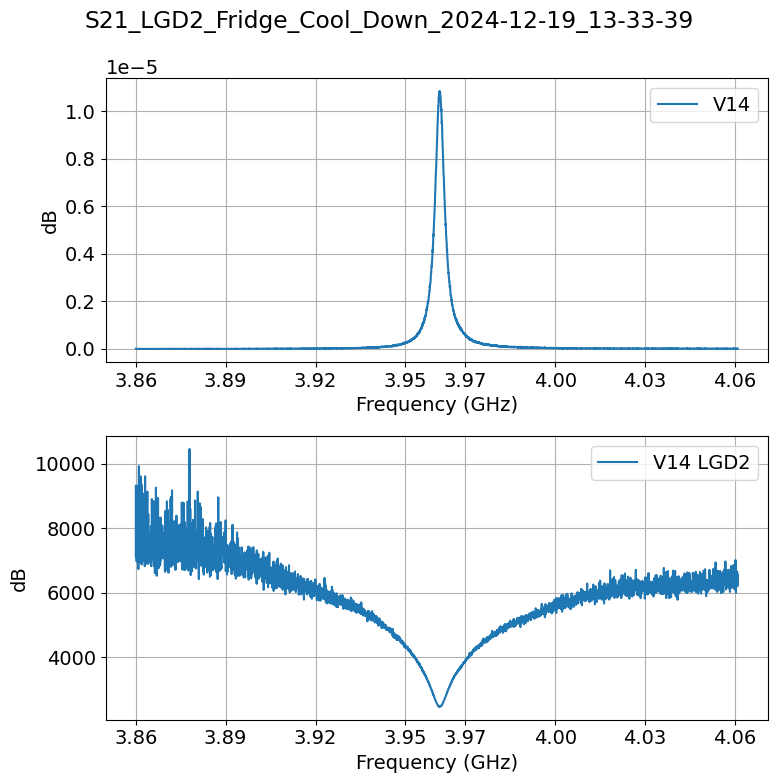

In [13]:
## Single Spectrum ##

data_file_wide = "data_vna/data_19-12/S21_LGD2_Fridge_Cool_Down_2024-12-19_13-33-39"
data_file_narrow = "data_vna/data_19-12/S21_LGD2_Fridge_Cool_Down_2024-12-19_13-33-39"

def read_fridge_VNA_data(file_path):
    # Read the data after the "BEGIN" line into a DataFrame
    data = pd.read_csv(file_path, skiprows=1)
    data.columns.values[0] = 'Frequency (GHz)'  # Change 'Column_1' to your desired name
    data.columns.values[1] = 'S21 (dB)'
    data.columns.values[2] = 'Date'  # Change 'Column_1' to your desired name
    data.columns.values[3] = 'Time'
    data["Frequency (GHz)"] = pd.to_numeric(data["Frequency (GHz)"], errors='coerce')
    data["Frequency (GHz)"] = data["Frequency (GHz)"]/1000
    data['S21 (dB)'] = pd.to_numeric(data['S21 (dB)'], errors='coerce')   
    return data

label ="S21_LGD2_Fridge_Cool_Down_2024-12-19_13-33-39"
cwd = os.getcwd()
mypath_wide = os.path.join(cwd, data_file_wide)
data_wide = mf.read_fridge_VNA_data(mypath_wide)
data_wide["S21 (dB)"] = mf.convert_dB_2_linear(data_wide["S21 (dB)"])


mypath_narrow = os.path.join(cwd, data_file_narrow)
data_narrow = mf.read_fridge_VNA_data(mypath_narrow)
fig  = plt.figure(figsize=(8,8))
plt.rc('font',size=14)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(data_wide["Frequency (GHz)"], data_wide["S21 (dB)"], label = "V14")
ax1.legend()
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("dB")
ax1.grid()
x_ticks = np.round(np.linspace(np.min(data_wide["Frequency (GHz)"]),np.max(data_wide["Frequency (GHz)"]), 8),2)
ax1.set_xticks(x_ticks)
ax1.legend()
mf.calculate_S21_features(data_wide, freq_range=[np.min(data_wide["Frequency (GHz)"]), np.max(data_wide["Frequency (GHz)"])], output_filename="results_vna_19-12/"+label)
ax2.plot(data_narrow["Frequency (GHz)"],np.abs(data_narrow["S21 (dB)"])**2, label ="V14 LGD2")
ax2.legend()
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("dB")
ax2.grid()
x_ticks = np.round(np.linspace(np.min(data_narrow["Frequency (GHz)"]),np.max(data_narrow["Frequency (GHz)"]), 8),2)
ax2.set_xticks(x_ticks)

fig.suptitle(label)
plt.tight_layout()


# save_folder = "results_vna_19-12"
# save_name = label
# if not os.path.exists(save_folder):
#     os.makedirs(save_folder)
# save_path = os.path.join(save_folder, save_name)
# plt.savefig(save_path)

plt.show()


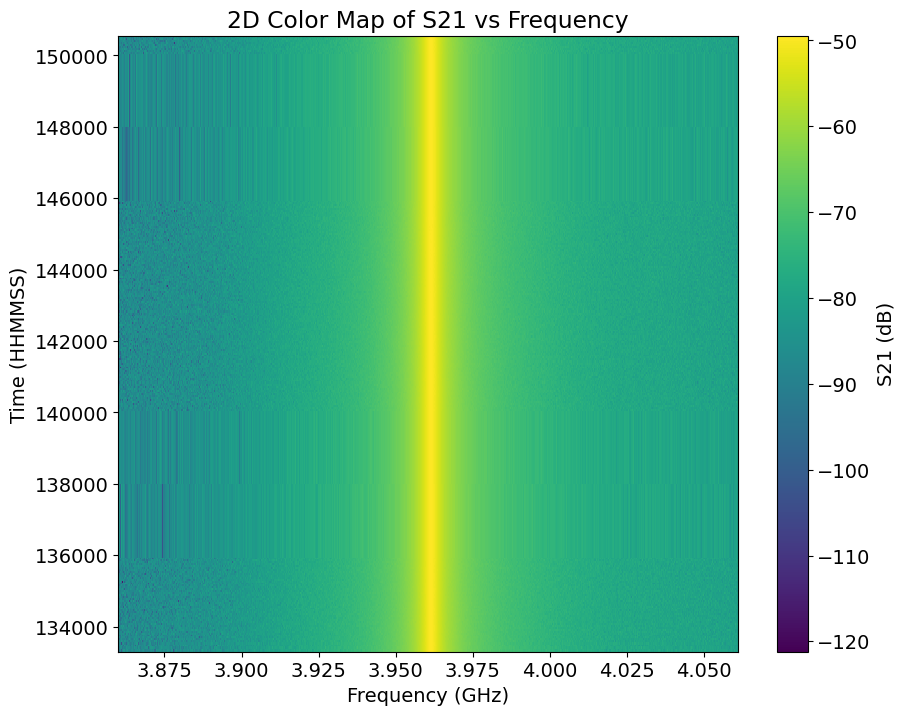

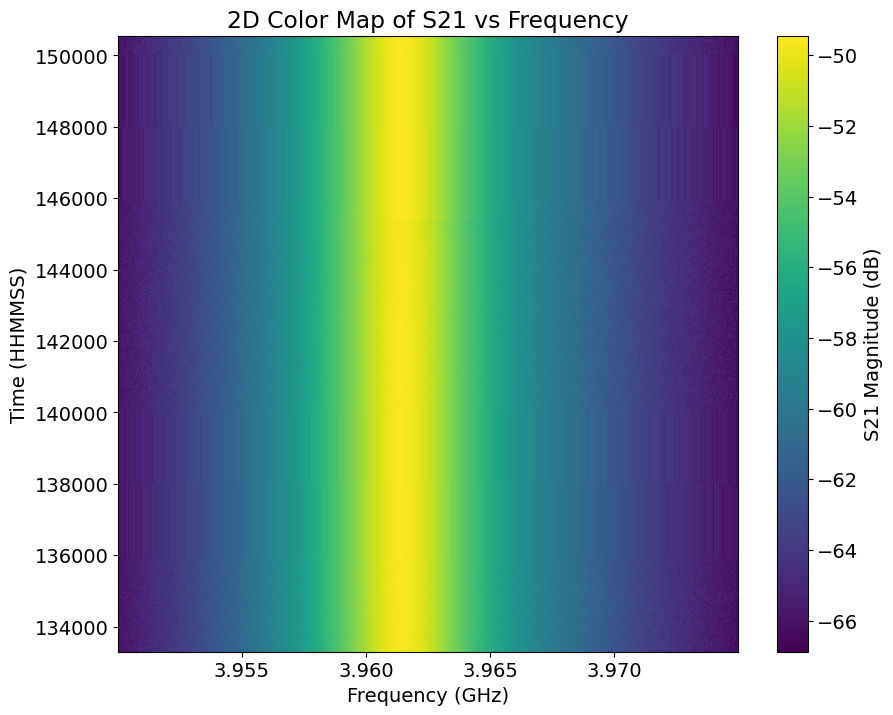

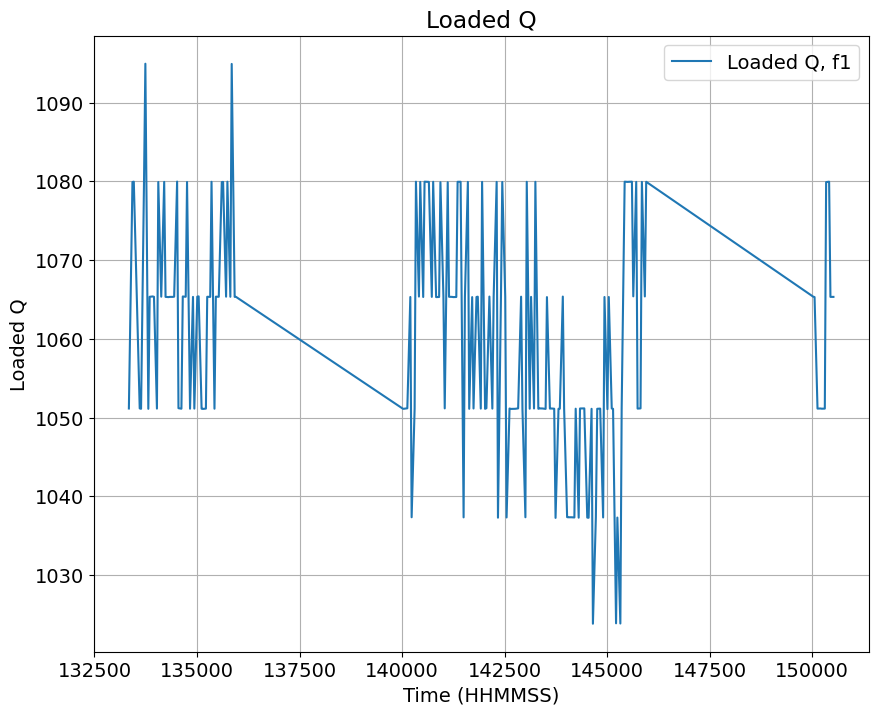

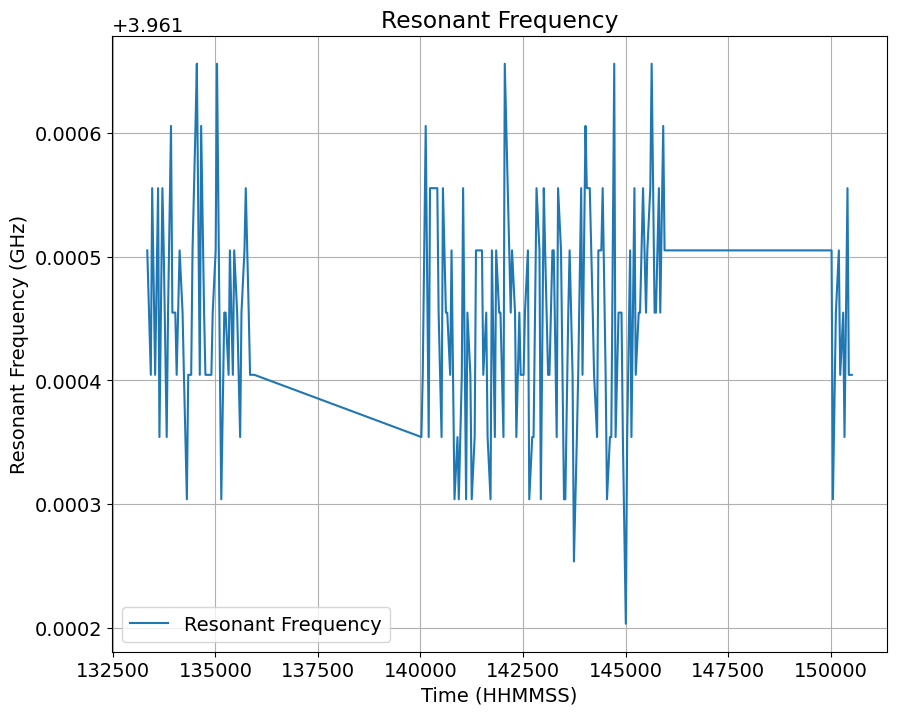

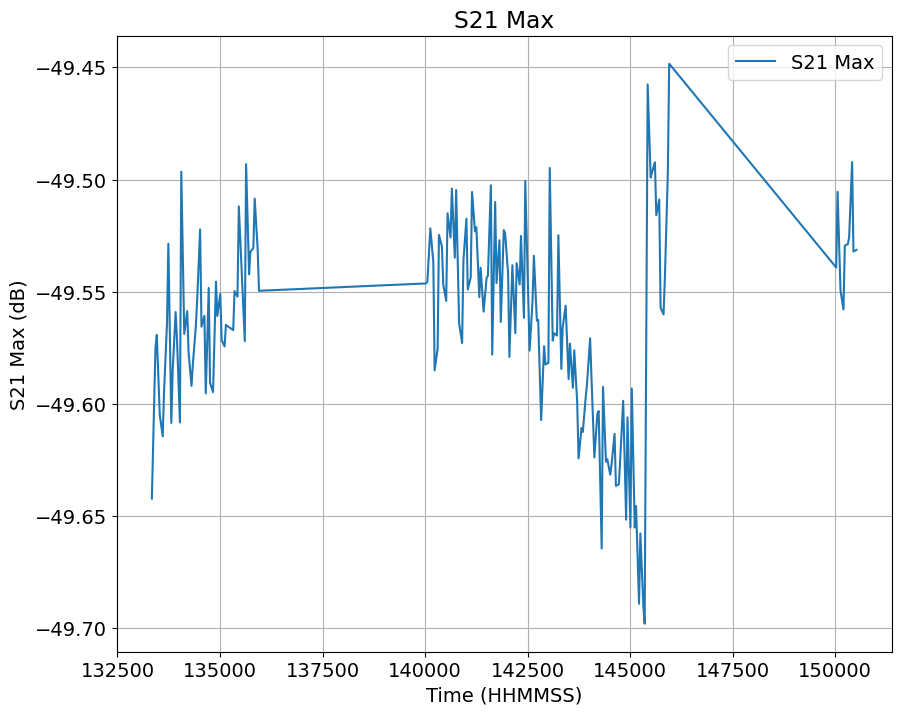

In [4]:
## MULTIPLE SPECTRA ## 

import os
import pandas as pd
import glob

path = "data_vna/data_19-12/"
data_files =  sorted(glob.glob(path +"*"))

aligned_frequencies = None
s21_magnitudes = []
spectra_times = []
loaded_q =[]
resonant_freq =[]
s21_max = [] 

# Process each file
for file in data_files:
    data = mf.read_fridge_VNA_data(file)
    time = file.split('_')[-1]
    time = int(time.replace("-", ""))
    spectra_times.append(time)

    features = mf.calculate_S21_features(data, [3.86, 4.06], to_print=False)
    loaded_q.append(features.get("Q_loaded"))
    resonant_freq.append(features.get("f_r"))
    s21_max.append(features.get("S_21_mag_at_f_r"))

    # Use the first file's frequencies as the reference grid
    if aligned_frequencies is None:
        aligned_frequencies = data["Frequency (GHz)"].values
    
    # Interpolate S21 data onto the reference frequency grid
    interp_s21 = np.interp(aligned_frequencies, data["Frequency (GHz)"], data["S21 (dB)"])
    s21_magnitudes.append(interp_s21)

# Convert to 2D array for plotting
s21_magnitudes = np.array(s21_magnitudes)
# Create a 2D color map plot
plt.figure(figsize=(10, 8))
plt.pcolormesh(aligned_frequencies, spectra_times, s21_magnitudes, shading='auto', cmap='viridis')
plt.colorbar(label="S21 (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Time (HHMMSS)")
plt.title("2D Color Map of S21 vs Frequency")
plt.show()

lower_bound_freq= 3.950
upper_bound_freq = 3.975
zoom_mask = (aligned_frequencies >= lower_bound_freq) & (aligned_frequencies <= upper_bound_freq)
zoomed_frequencies = aligned_frequencies[zoom_mask]
zoomed_s21_magnitudes = s21_magnitudes[:, zoom_mask]

plt.figure(figsize=(10, 8))
plt.pcolormesh(zoomed_frequencies, spectra_times, zoomed_s21_magnitudes, shading='auto', cmap='viridis')
plt.colorbar(label="S21 Magnitude (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Time (HHMMSS)")
plt.title("2D Color Map of S21 vs Frequency")
plt.show()


# First Plot: Loaded Q
fig1 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.plot(spectra_times, loaded_q, label="Loaded Q, f1")
plt.legend()
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Loaded Q")
plt.title("Loaded Q")
plt.grid()
plt.show()

# Second Plot: Resonant Frequency
fig2 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.plot(spectra_times, resonant_freq, label="Resonant Frequency")
plt.legend()
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Resonant Frequency (GHz)")
plt.title("Resonant Frequency")
plt.grid()
plt.show()

# Third Plot: S21 Max
fig3 = plt.figure(figsize=(10, 8))
plt.rc("font", size=14)
plt.plot(spectra_times, s21_max, label="S21 Max")
plt.legend()
plt.xlabel("Time (HHMMSS)")
plt.ylabel("S21 Max (dB)")
plt.title("S21 Max")
plt.grid()
plt.show()

Fitted Paramaters:  [1.08227273e-05 3.96148849e+00 1.87967460e-03 7.83072535e-09]
S_21 at resonant frequency (f_r) = -49.653826388076524
Resonant Frequency (f_r) = 3.9615050000000003
Q loaded = 1051.14560530671
Q unloaded = 3.470588443223803
Delta F = 0.0037687500000003205
f1 = 3.9595955
f2 = 3.96336425
S21 at f1 -52.69137601283091
S21 at f2 -52.651617905525825
Q Loaded Uncertainty 0.03775424316938744 %
Q Unloaded Uncertainty 0.00012465393886901583 %
R-SQUARED =  0.9895047090274547


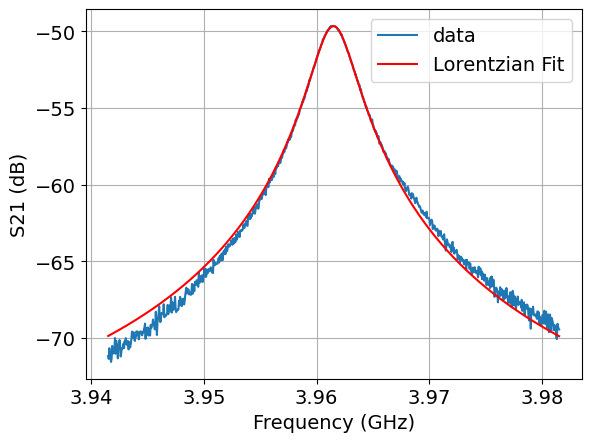

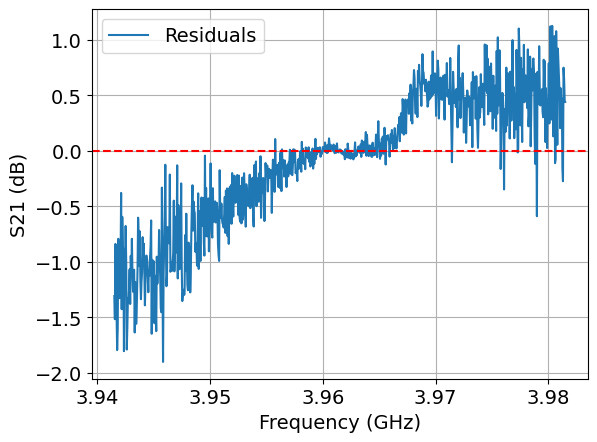

In [15]:
## MUlTIPLE SPECTRA F1 FREQUENCY & LORENTZIAN FIT ## 

def lorentzian(x, a,x_0, b, c): 
    #### Define Lorentzuab function ####
    # arguments: 
    # a = peak amplitude
    # x_0 = center of peak
    # b = HWHM 
    # c = baseline offset
    return a * b**2 / ((x - x_0)**2 + b**2) + c

def lorentzian_smoothing(y_data, x_kernal=np.linspace(-1, 1, 101), kernal_width= 0.1): 
    # Define Lorentzian kernel
    kernel_width = 0.1  # Adjust based on your resolution needs
    x_kernel = np.linspace(-1, 1, 101)  # Kernel range (adjust size as needed)
    lorentzian= kernel_width / (np.pi * (x_kernel**2 + kernel_width**2))

    # Normalize kernel (important for smoothing)
    lorentzian /= np.sum(lorentzian)

    # Convolve data with Lorentzian kernel
    smoothed_y = convolve(y_data, lorentzian, mode='same')
    return smoothed_y

def fit_lorentzian_to_transmission(): 
    return

def calculate_r_squared(y_data, y_pred):
    """
    Calculate the coefficient of determination (R^2).

    Parameters:
    - y_data (array-like): Observed data.
    - y_pred (array-like): Predicted data.

    Returns:
    - r2 (float): Coefficient of determination (R^2).
    """
    # Convert to numpy arrays for computation
    y_data = np.array(y_data)
    y_pred = np.array(y_pred)
    
    # Calculate the mean of observed values
    y_mean = np.mean(y_data)
    
    # Calculate SS_res (Residual Sum of Squares)
    ss_res = np.sum((y_data - y_pred) ** 2)
    
    # Calculate SS_tot (Total Sum of Squares)
    ss_tot = np.sum((y_data - y_mean) ** 2)
    
    # Calculate R^2
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

data_file = "data_vna/data_19-12/S21_LGD2_Fridge_Cool_Down_2024-12-19_13-33-39"

label =os.path.basename(data_file)
cwd = os.getcwd()
mypath = os.path.join(cwd, data_file)
data = mf.read_fridge_VNA_data(mypath)
y_data = data['S21 (dB)']
x_data = data['Frequency (GHz)']

## Filters: 

#y_data = lorentzian_smoothing(y_data)
#y_data = mf.low_pass_band_filter_fft(1000, x_data, y_data, plot_check=False)

mask = (x_data >= (3.9615050000000003-0.02)) & (x_data <= (3.9615050000000003+0.02))
x_data = x_data[mask]
y_data = y_data[mask]

# Convert to Linear for graph fitting
y_data = mf.convert_dB_2_linear(y_data)

## Initial Guess for lorenzian fit
x_0 = 3.9615050000000003
a = 1e-5#-49.6422796
b = 0.0037687500000003205/2
c = 0
initial_guess = [a, x_0, b, c] # [a, x_0, b, c]
params, params_covariance = curve_fit(lorentzian,x_data, y_data,p0=initial_guess)

## Check params 
print("Fitted Paramaters: ", params)

# Plot the data and the fit
fitted_y = lorentzian(x_data, *params)


fitted_y = mf.convert_linear_2_dB(fitted_y)
y_data = mf.convert_linear_2_dB(y_data)
data_lorentizian = pd.DataFrame({"Frequency (GHz)": x_data, "S21 (dB)": fitted_y}) 
mf.calculate_S21_features(data_lorentizian, [3.9615050000000003-0.02,3.9615050000000003+0.02 ])

print("R-SQUARED = ", calculate_r_squared(y_data, fitted_y))

plt.plot(x_data, y_data, label="data")
plt.plot(x_data, fitted_y, color="red", label="Lorentzian Fit")
plt.xlabel("Frequency (GHz)")
plt.ylabel("S21 (dB)")
plt.grid()
plt.legend()
plt.show()

residuals = y_data - fitted_y
plt.plot(x_data, residuals, label="Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Frequency (GHz)")
plt.ylabel("S21 (dB)")
plt.legend()
plt.grid()
plt.show()


4001


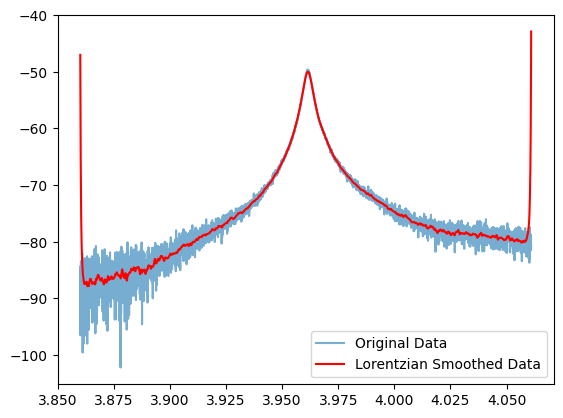

In [42]:
#### LORENTZIAN SMOOTHING ####

import numpy as np
from scipy.signal import convolve

def lorentzian_smoothing(y_data, x_kernal=np.linspace(-1, 1, 101), kernal_width= 0.1): 
    # Define Lorentzian kernel
    kernel_width = 0.1  # Adjust based on your resolution needs
    x_kernel = np.linspace(-1, 1, 101)  # Kernel range (adjust size as needed)
    lorentzian= kernel_width / (np.pi * (x_kernel**2 + kernel_width**2))

    # Normalize kernel (important for smoothing)
    lorentzian /= np.sum(lorentzian)

    # Convolve data with Lorentzian kernel
    smoothed_y = convolve(y_data, lorentzian, mode='same')
    return smoothed_y

data_file = "data_vna/data_19-12/S21_LGD2_Fridge_Cool_Down_2024-12-19_13-33-39"

label =os.path.basename(data_file)
cwd = os.getcwd()
mypath = os.path.join(cwd, data_file)
data = mf.read_fridge_VNA_data(mypath)
y_data = data['S21 (dB)']
x_data = data['Frequency (GHz)']

x_kernel=np.linspace(-1, 1, 101)
kernel_width = 0.1
smoothed_y = lorentzian_smoothing(y_data, x_kernel,kernel_width)

print(len(smoothed_y))
# Plot original and smoothed data
import matplotlib.pyplot as plt
plt.plot(x_data, y_data, label="Original Data", alpha=0.6)
plt.plot(x_data, smoothed_y, label="Lorentzian Smoothed Data", color="red")
plt.legend()
plt.show()


In [36]:
####  VOIGT FUNCTION FITTING ####

def voigt_model(x, amplitude, center, sigma, gamma):
    """
    Voigt model for curve fitting.
    
    Parameters:
    - x: Independent variable (array)
    - amplitude: Peak amplitude
    - center: Center of the peak
    - sigma: Standard deviation of the Gaussian component
    - gamma: HWHM of the Lorentzian component
    
    Returns:
    - Scaled Voigt profile values.
    """
    return amplitude * voigt_profile(x - center, sigma, gamma)



data_file = "data_vna/data_19-12/S21_LGD2_Fridge_Cool_Down_2024-12-19_13-33-39"

label =os.path.basename(data_file)
cwd = os.getcwd()
mypath = os.path.join(cwd, data_file)
data = mf.read_fridge_VNA_data(mypath)
y_data = data['S21 (dB)']
x_data = data['Frequency (GHz)']

mask = (x_data >= 3.94) & (x_data <= 3.98)
x_data = x_data[mask]
y_data = y_data[mask]
y_data = mf.convert_dB_2_linear(y_data)
# y_data = mf.low_pass_band_filter_fft(200, x_data, y_data, plot_check=False)

print(np.min(y_data))
## Initial Guess
center = 3.9615050000000003
amplitude = 1e-5#-49.6422796
gamma = 0.0037687500000003205/2
baseline = -80
guass_BWR = 10000/1e9
sigma = guass_BWR/(2*np.sqrt(2*np.log(2))) #Hz
sigma = 1
print(sigma)
initial_guess = [amplitude, center, sigma, gamma]

## Curve Fitting
params, params_covariance = curve_fit(voigt_model, x_data, y_data, p0=initial_guess, maxfev=15000)

fitted_amplitude, fitted_center, fitted_sigma, fitted_gamma = params
print(f"Fitted parameters:")
print(f"Amplitude: {fitted_amplitude}")
print(f"Center: {fitted_center}")
print(f"Sigma: {fitted_sigma}")
print(f"Gamma: {fitted_gamma}")

# Generate fitted curve for plotting
fitted_curve = voigt_model(x_data, *params)

plt.plot(x_data, y_data, label="data")
plt.plot(x_data, fitted_curve, color="red", label="Voigt Fit")
plt.xlabel("Frequency (GHz)")
plt.ylabel("S21 (dB)")
plt.grid()
plt.legend()
plt.show()

residuals = y_data - fitted_curve
plt.plot(x_data, residuals, label="Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Frequency (GHz)")
plt.ylabel("S21 (dB)")
plt.legend()
plt.grid()
plt.show()


5.431491572223814e-08
1


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 15000.